<a href="https://colab.research.google.com/github/Singular-Brain/bindsnet/blob/master/lc_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setups

In [1]:
!pip install -q git+https://github.com/Singular-Brain/bindsnet

     |████████████████████████████████| 120 kB 8.4 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 72 kB 1.2 MB/s 
     |████████████████████████████████| 280 kB 13.8 MB/s 
     |████████████████████████████████| 28.5 MB 33 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!wget https://data.deepai.org/mnist.zip
!mkdir -p ../data/MNIST/TorchvisionDatasetWrapper/raw
!unzip mnist.zip -d ../data/MNIST/TorchvisionDatasetWrapper/raw/

--2021-07-29 04:47:31--  https://data.deepai.org/mnist.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11597176 (11M) [application/x-zip-compressed]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  11.06M  8.22MB/s    in 1.3s    

2021-07-29 04:47:33 (8.22 MB/s) - ‘mnist.zip’ saved [11597176/11597176]

Archive:  mnist.zip
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz  
  inflating: ../data/MNIST/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz  


In [3]:
from bindsnet.network.nodes import Nodes
import os
import torch
import torchvision
import numpy as np
import argparse
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm.notebook import tqdm

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import LocalConnection, Connection
from bindsnet.network.monitors import Monitor, AbstractMonitor
from bindsnet.learning import PostPre, MSTDP, MSTDPET 
from bindsnet.learning.reward import DynamicDopamineInjection
from bindsnet.utils import get_square_assignments, get_square_weights
from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.analysis.plotting import (
    plot_input,
    plot_assignments,
    plot_performance,
    plot_weights,
    plot_spikes,
    plot_voltages,
)

## Set up hyper-parameters

In [4]:
n_neurons = 100
n_train = 5000
n_test = 300
n_val = 200
theta_plus = 0.05
time = 250
dt = 1
intensity = 128
train = True
gpu = True
device_id = 0
n_classes = 10
neuron_per_class = 10
seed = 2045 # The Singularity is Near!

reward_kwargs = {
    'dopaminergic_layer': 'output', 
    'n_labels': n_classes,
    'neuron_per_class': neuron_per_class,
    'dopamine_per_spike': 0.2, 
    'tc_reward': 20,
    'dopamine_base': 0.02,
}

## Sets up Gpu use


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

if not train:
    update_interval = n_test

Running on Device =  cuda


# Design network

## Reward Monitor

In [6]:
class RewardMonitor(AbstractMonitor):
    # language=rst
    """
    Records state variables of interest.
    """

    def __init__(
        self,
        time: None,
        batch_size: int = 1,
        device: str = "cpu",
    ):
        # language=rst
        """
        Constructs a ``Monitor`` object.

        :param obj: An object to record state variables from during network simulation.
        :param state_vars: Iterable of strings indicating names of state variables to record.
        :param time: If not ``None``, pre-allocate memory for state variable recording.
        :param device: Allow the monitor to be on different device separate from Network device
        """
        super().__init__()

        self.time = time
        self.batch_size = batch_size
        self.device = device

        # if time is not specified the monitor variable accumulate the logs
        if self.time is None:
            self.device = "cpu"

        self.recording = []
        self.reset_state_variables()

    def get(self,) -> torch.Tensor:
        # language=rst
        """
        Return recording to user.

        :return: Tensor of shape ``[time, n_1, ..., n_k]``, where ``[n_1, ..., n_k]`` is the shape of the recorded state
        variable.
        Note, if time == `None`, get return the logs and empty the monitor variable

        """
        # return_logs = torch.as_tensor(self.recording)
        # if self.time is None:
        #     self.recording = []
        return self.recording

    def record(self, **kwargs) -> None:
        # language=rst
        """
        Appends the current value of the recorded state variables to the recording.
        """
        self.recording.append(kwargs["reward"])
        # remove the oldest element (first in the list)
        # if self.time is not None:
        #     self.recording.pop(0)

    def reset_state_variables(self) -> None:
        # language=rst
        """
        Resets recordings to empty ``List``s.
        """
        self.recording = []


In [90]:
C = 50
K = 16
S = 4
crop_size = 20
theta_plus = 0.05   ## Adaptive LIF
inh_factor = 0.5
wmin = -1.0
wmax = 1.0

compute_size = lambda inp_size, k, s: int((inp_size-k)/s) + 1

### Reward function
reward_fn = DynamicDopamineInjection
network = Network(dt = 1, reward_fn = reward_fn)

### nodes
inp = Input(shape= [1,20,20], traces=True)

main = AdaptiveLIFNodes(shape= [C, compute_size(20, K, S), compute_size(20, K, S)], traces=True, tc_trace=20, theta_plus=theta_plus)
#main = LIFNodes(shape= [C, compute_size(20, K, S), compute_size(20, K, S)], traces=True)

# TODO: Diehl & Cook 2015 (v2) 
out = AdaptiveLIFNodes(n= 100, traces=True, tc_trace=20, theta_plus=theta_plus)

### connections 
LC = LocalConnection(inp, main, K, S, C, nu = [1e-2, 1e-4], update_rule = MSTDPET, wmin = wmin, wmax= wmax)
#LC.w = torch.nn.init.xavier_normal_(LC.w, gain=1.0)

main_out = Connection(main, out, nu = [1e-2, 1e-4], update_rule = MSTDPET, wmin = wmin, wmax= wmax)
#main_out.w = torch.nn.init.xavier_normal_(main_out.w, gain=1.0)


w = -inh_factor * torch.ones(out.n, out.n)
for c in range(n_classes):
    ind = slice(c*neuron_per_class,(c+1)*neuron_per_class)
    w[ind, ind] = 0


out_recurrent_inhibition = Connection(
    source=out,
    target=out,
    w=w,
    wmin=-inh_factor,
    wmax=0,
    nu = 1e-4,
)

network.add_layer(main, "main")
network.add_layer(inp, "input")
network.add_layer(out, "output")
network.add_connection(LC, "input", "main")
network.add_connection(main_out, "main", "output")
network.add_connection(out_recurrent_inhibition, "output", "output")

# Directs network to GPU
if gpu:
    network.to("cuda")

# Voltage recording for excitatory and inhibitory layers.
main_monitor = Monitor(network.layers["main"], ["v"], time=time, device=device)
output_monitor = Monitor(network.layers["output"], ["v"], time=time, device=device)
reward_monitor = RewardMonitor(time =time)
network.add_monitor(main_monitor, name="main")
network.add_monitor(output_monitor, name="output")
network.add_monitor(reward_monitor, name="reward")



# Load Dataset

In [91]:
class ClassSelector(torch.utils.data.sampler.Sampler):
    """Select target classes from the dataset"""
    def __init__(self, target_classes, data_source):
        self.mask = torch.tensor([1 if data_source[i][1] in target_classes else 0 for i in range(len(data_source))])
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)

In [92]:
# Load MNIST data.
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Lambda(lambda x: x * intensity),
        transforms.CenterCrop(crop_size)]
    ),
)

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True,
                                        #  sampler = ClassSelector(
                                        #         target_classes = (2,4),
                                        #         data_source = dataset)
                                         )

# Load test dataset
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(),
        transforms.Lambda(lambda x: x * intensity),
        transforms.CenterCrop(crop_size)]
    ),
)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True,
                                        #  sampler = ClassSelector(
                                        #         target_classes = (2,4),
                                        #         data_source = dataset)
                                         )

# Evaluation Utils

In [93]:
def evaluate(network, val_loader):
    correct = 0
    false = 0
    spikes_val = {}
    for layer in set(network.layers):
        spikes_val[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
        network.add_monitor(spikes_val[layer], name="%s_spikes" % layer)

    network.train(False)

    for (i, datum) in enumerate(val_loader):
        if i > n_val:
            break

        image = datum["encoded_image"]
        label = datum["label"]

        # Run the network on the input.
        if gpu:
            inputs = {"input": image.cuda().view(time, 1, 1, 20, 20)}
        else:
            inputs = {"input": image.view(time, 1, 1, 20, 20)}
        network.run(inputs=inputs, time=time, **reward_kwargs, labels=label)

        # Add to spikes recording.
        output_spikes = spikes_val["output"].get("s").view(time, n_classes, neuron_per_class).sum(0)
        predicted_label = torch.argmax(output_spikes.sum(1))

        if predicted_label == label:
            correct+=1
        else:
            false+=1
    val_acc = 100 * correct/(correct + false)
    return val_acc

# Train

In [ ]:
# Train the network.
print("Begin training.\n")

correct = 0
false = 0
val_interval = 250
spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

val_acc = 0.0

reward_history = []
pbar = tqdm(total=n_train)
for (i, datum) in enumerate(dataloader):
    if i > n_train:
        break

    image = datum["encoded_image"]
    label = datum["label"]

    # Run the network on the input.
    if gpu:
        inputs = {"input": image.cuda().view(time, 1, 1, 20, 20)}
    else:
        inputs = {"input": image.view(time, 1, 1, 20, 20)}
    network.run(inputs=inputs, time=time, **reward_kwargs, labels = label)

    # Get voltage recording.
    main_voltage = main_monitor.get("v")
    out_voltage = output_monitor.get("v")
    reward_history.append(reward_monitor.get())

    # Add to spikes recording.
    output_spikes = spikes["output"].get("s").view(time, n_classes, neuron_per_class).sum(0)
    predicted_label = torch.argmax(output_spikes.sum(1))

    print("\routput", output_spikes.sum(1), 'predicted_label:', predicted_label.item(), 'GT:', label.item(), end = '')
    # print('main', spikes["main"].get("s").sum(0).sum(1))
    # print("input", spikes["input"].get("s").sum(0).sum(1))
    # if  i % val_interval == 0 and i!=0:
    #     if i != n_train:
    #         correct = 0
    #         false = 0
    #     val_acc = evaluate(network, val_loader)
    #     network.train(mode=True)

    if predicted_label == label:
        correct+=1
    else:
        false+=1
        
    acc = 100 * correct/(correct + false)
    # network.reset_state_variables()  # Reset state variables.
    
    pbar.set_description_str("Running accuracy: " + "{:.2f}".format(acc) + "%, " + "Current val accuracy: " + "{:.2f}".format(val_acc) + "%, ")
    pbar.update()

Begin training.



  0%|          | 0/5000 [00:00<?, ?it/s]

output tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0]) predicted_label: 3 GT: 5

('input', 'main')
tensor([[ 0.8232,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3769,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2339,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1188],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1439],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.4439]])
(-1.0000051259994507, 1.0000135898590088)


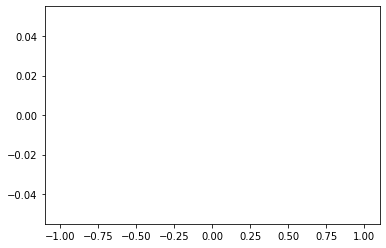

('main', 'output')
tensor([[-0.9580, -0.4543, -0.0117,  ..., -0.7069, -0.7988, -0.9462],
        [-0.2655,  0.9095, -0.7128,  ...,  0.7128,  0.4573, -0.6863],
        [ 0.5858,  0.1315,  0.5714,  ...,  0.6636, -0.7231,  0.2240],
        ...,
        [-0.5069,  0.5318,  0.9923,  ..., -0.1741,  0.5249,  0.6005],
        [-0.6213, -0.6972,  0.1976,  ..., -0.6090, -0.5876,  0.3995],
        [-0.9182,  0.0442,  0.5837,  ..., -0.2019,  0.8700, -0.9570]])
(-1.0, 1.0)


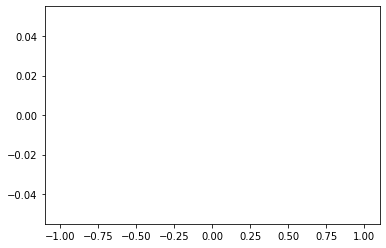

In [89]:
from matplotlib import pyplot as plt
for c in network.connections:
    print(c)
    w = network.connections[c].w.cpu()
    print(w)
    plt.hist(torch.histc(w, bins=200).tolist(),bins = 200, range = (w.min().item(), w.max().item()))
    print((w.min().item(), w.max().item()))
    plt.show()

In [33]:
w = input_main.w.cpu()
plt.hist(torch.histc(w), range = (w.min().item(), w.max().item()))

NameError: ignored

In [12]:
output_spikes = spikes["output"].get("s").view(time, n_classes, neuron_per_class).sum(0)
predicted_label = torch.argmax(output_spikes.sum(1))
print("\routput", output_spikes.sum(1), 'predicted_label:', predicted_label.item(), 'GT:', label.item(), end = '')
reward_history

output tensor([311, 306, 306, 304, 315, 308, 311, 309, 305, 302]) predicted_label: 4 GT: 4

[tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(0.0200, device='cuda:0'),
 tensor(2.0200, device='cuda:0'),
 tensor(1.9225, device='cuda:0'),
 tensor(1.8297, device='cuda:0'),
 tensor(1.7414, device='cuda:0'),
 tensor(1.6575, device='cuda:0'),
 tensor(1.5776, device='cuda:0'),
 tensor(1.5016, device='cuda:0'),
 tensor(1.4294, device='cuda:0'),
 tensor(3.3606, device='cuda:0'),
 tensor(3.1977, device='cuda:0'),
 tensor(3.0427, device='cuda:0'),
 tensor(2.8953, device='cuda:0'),
 tensor(2.7551, device='cuda:0'),
 tensor(2.6217, device='cuda:0'),
 tensor(2.4948, device='cuda:0'),
 tensor(2.3741, device='cuda:0'),
 tensor(3.6593, device='cuda:0'),
 tensor(3.4818, device='cuda:0'),
 tensor(3.9130, device='cuda:0'),
 tensor(3.7231, device='cuda:0'),
 tensor(3.5425, device='cuda:0'),
 tensor(3.3707

# Kernel 

In [ ]:
from abc import ABC, abstractmethod
from typing import Union, Tuple, Optional, Sequence
from torch.nn.modules.utils import _pair

In [ ]:
class AbstractKernel(ABC):
	r"""Base class for generating image filter kernels such as Gabor, DoG, etc. Each subclass should override :attr:`__call__` function.
	"""
	def __init__(self, kernel_size: Union[int, Tuple[int, int]]):
    """
    Instantiates a ``Filter Kernel`` object.

    :param kernel_size: Horizontal and vertical size of convolutional kernels.
    """
		self.kernel_size = _pair(kenel_size)

	def __call__(self):
		pass


In [ ]:
class DoG_Kernel(AbstractKernel):
	r"""Generates DoG filter kernels.
	"""
	def __init__(self, 
                 kernel_size: Union[int, Tuple[int, int]], 
                 sigma1 : float,
                 sigma2 : float):
        """
		:param kernel_size: Horizontal and vertical size of DOG kernels.(If pass int, we consider it as a square filter) 
		:param sigma1 : The sigma parameter for the first Gaussian function.
		:param sigma2 : The sigma parameter for the second Gaussian function.
		"""
        super(DoG_Kernel, self).__init__(kernel_size)
		self.sigma1 = sigma1
		self.sigma2 = sigma2

	# returns a 2d tensor corresponding to the requested DoG filter
	def __call__(self):
		k = self.kernel_size//2
		x, y = np.mgrid[-k:k+1:1, -k:k+1:1]
		a = 1.0 / (2 * math.pi)
		prod = x*x + y*y
		f1 = (1/(self.sigma1*self.sigma1)) * np.exp(-0.5 * (1/(self.sigma1*self.sigma1)) * (prod))
		f2 = (1/(self.sigma2*self.sigma2)) * np.exp(-0.5 * (1/(self.sigma2*self.sigma2)) * (prod))
		dog = a * (f1-f2)
		dog_mean = np.mean(dog)
		dog = dog - dog_mean
		dog_max = np.max(dog)
		dog = dog / dog_max
		dog_tensor = torch.from_numpy(dog)
		return dog_tensor.float()